In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline

In [2]:
class Process:
    """Signal processing"""
    rate = 1

    
class Gain(Process):
    """Apply a flat gain."""
    def __init__(self, g):
        self.gain = g

    def __call__(self, x):
        return x*self.gain


class US(Process):
    """Upsampler, zero stuffer."""
    def __init__(self, r):
        self.rate = r

    def __call__(self, x):
        return np.vstack((x*self.rate, np.zeros((self.rate - 1, len(x))))).T.ravel()


class DS(Process):
    """Downsampler"""
    def __init__(self, r, prefer_mid=True):
        self.r = r
        self.rate = 1./r
        self.prefer_mid = prefer_mid
        
    def __call__(self, x):
        if self.prefer_mid:
            start = (len(x) - 1) // 2 % self.r
        else:
            start = 0
        return x[start::self.r]

    
class FIR(Process):
    """Finite impulse response filter."""
    def __init__(self, b, a=1):
        b = np.atleast_1d(b)
        # b[np.fabs(b) < 3e-7] = 0
        self.b, self.a = b, a

    def __call__(self, x):
        return np.convolve(x, self.b)/self.a

    def quantize(self, m):
        self.b = np.round(self.b*m).astype(np.int32)
        self.a = np.round(self.a*m).astype(np.int32)
        return self
    
    def freqz(self, worN=1024):
        return signal.freqz(self.b, self.a, worN)

    def plot_freq(self, ax, color=None, r=1, f=1, inset=True, worN=1024):
        s, h = self.freqz(worN)
        s /= np.pi*f
        hh = np.absolute(h/r)
        ax.plot(s, hh, color=color)
        if inset:
            ax.plot(s, np.fabs(1 - hh), color=color)

    def plot_time(self, ax, color=None, r=1):
        ax.step(np.arange(len(self.b))/r, self.b/self.a, color=color)


class LPF(FIR):
    """Lowpass FIR filter with Remez/Parks-McClellan"""
    def __init__(self, n, wa, wb, k=(1., 1), g=(1., 0)):
        b = signal.remez(
            numtaps=n,
            bands=(0, wa, wb, 1.),
            desired=g,
            weight=k,
            fs=2,
            grid_density=256)
        FIR.__init__(self, b)


class HBF(LPF):
    """Half-band filter"""
    def __init__(self, n, w):
        LPF.__init__(self, 4*n - 1, w, 1 - w)


class FIR2(FIR):
    """Use firwin2 to construct a FIR"""
    def __init__(self, n, w, g):
        b = signal.firwin2(n, w, g)
        FIR.__init__(self, b)


class FIRLS(FIR):
    """Use firls to construct a FIR"""
    def __init__(self, n, w, g, weight=None):
        b = signal.firls(n, w, g, weight)
        FIR.__init__(self, b)


class CIC(FIR):
    """Cascaded integrator comb interpolator"""
    # CIC: http://www.tsdconseil.fr/log/scriptscilab/cic/cic-en.pdf
    # resampling: http://www.ee.ic.ac.uk/hp/staff/dmb/courses/DSPDF/01300_Resampling.pdf
    def __init__(self, r, m, n):
        # self.rate = r if r > 0 else -1/r
        self.rate = 1  # use a US/DS before to implement the rate change
        self.r = r  # rate change
        self.m = m  # delay
        self.n = n  # filter order
        b = 1
        a = 1
        for i in range(n):
            b = np.convolve(np.ones(abs(r)*m, np.int32), b)
            a *= abs(r)*m
        FIR.__init__(self, b, a)
        #b = 1  #[max(r, 1)] + [0]*(max(r, 1) - 1)
        #b = b[::max(1, -r)]/max(1, -r)

    def disabled__call__(self, x):  # not yet working, instead defer to FIR
        k = (1 << 30)/np.fabs(x).max()
        x = (x*k).astype(np.int64)
        if self.r > 0:
            for i in range(self.n):
                x = np.diff(np.r_[0, x], self.m)
            x = US(self.r)(x)
            for i in range(self.n):
                x = np.cumsum(x)
        else:
            for i in range(self.n):
                x = np.cumsum(x)
            x = DS(-self.r)(x)
            for i in range(self.n):
                x = np.diff(np.r_[0, x], self.m)
        return x/k

(array([   24,   -85,   281, -1314, 55856, -1314,   281,   -85,    24],
       dtype=int32),
 65536)

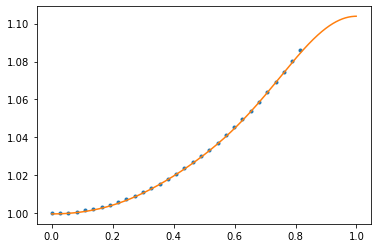

In [3]:
# CIC droop compensation filter

# frequency nodes
s = np.linspace(1e-9, .4*2*1.02, 31)

rm, n, k = 5, 5, 20/1.*2
# cic response
h = (np.sin(np.pi*rm*s/k)/(rm*np.sin(np.pi*s/k)))**n

plt.plot(s, 1/np.absolute(h), ".")

ciccomp = FIR(signal.firls(
    9,
    np.repeat(s, 2)[1:-1],
    1/np.absolute(np.repeat(h, 2)[1:-1])
))
# ciccomp.b /= ciccomp.b.sum()
# include the final CIC gain and post-scaling here
ciccomp.b *= .9995*(2.**9/5**4)
ciccomp.quantize(1 << 16)
FIR(Gain(5**4/2.**9)(ciccomp([1.]))).plot_freq(plt.gca(), inset=False)
# ciccomp coefficients:
ciccomp.b, ciccomp.a

Text(0.5, 0, 'time (1/f_DAC)')

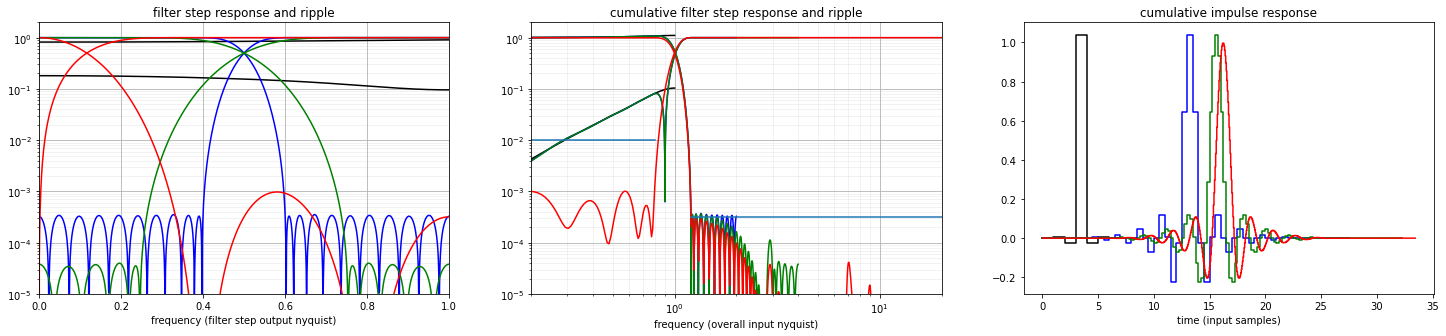

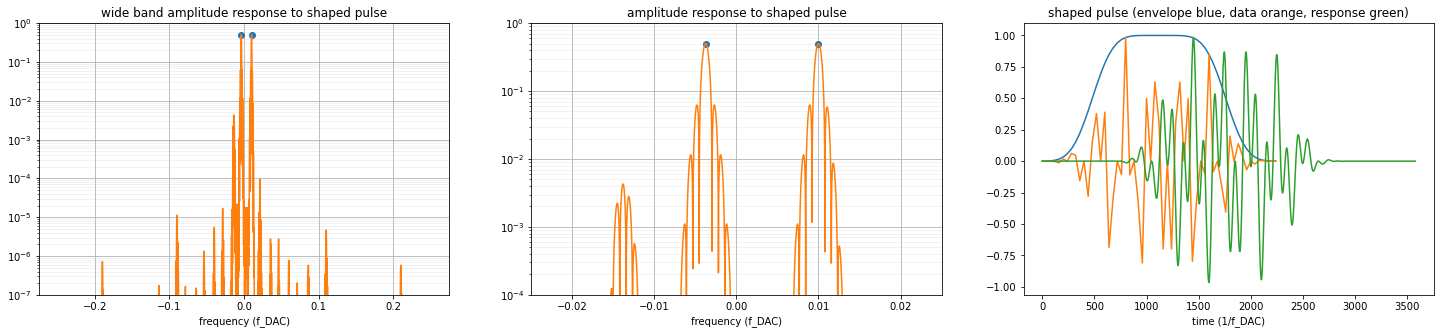

In [5]:
# Phaser interpolation filter, 20x

steps = [
    # 1/10  samples per cycles
    Gain(5**4/2.**9),  # compensate ciccomp+cic+shift gain
    # 1/10
    ciccomp,
    # 1/10
    US(2), HBF(10, .4).quantize(1 << 18),
    # 1/5
    US(2), HBF(5, 1/4.).quantize(1 << 18),
    # 2/5
    US(5), CIC(5, 1, 5),
    # 2/1
]

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
x = np.ones(1)
ax[2].step(np.arange(len(x)), x)
r = 1.

colors = list("kbgrcm")
for step in steps:
    r *= step.rate
    x = step(x)
    # print(step, x)
    if hasattr(step, "plot_freq"):
        color = colors.pop(0)
        step.plot_freq(ax[0], r=1, color=color)
        q = FIR(b=x)
        q.plot_freq(ax[1], r=r, f=1/r, color=color, inset=True, worN=2048)
        q.plot_time(ax[2], r=r, color=color)

ax[0].grid()
ax[0].grid(which="minor", alpha=.2)
ax[0].set_ylim(1e-5, 2)
ax[0].set_xlim(0, 1)
ax[0].set_yscale("log")
ax[0].set_xlabel("frequency (filter step output nyquist)")
ax[0].set_title("filter step response and ripple")
ax[1].grid()
ax[1].grid(which="minor", alpha=.2)
ax[1].set_ylim(1e-5, 2)
#ax[1].set_ylim(.9, 1.1)
ax[1].set_xlim(1e-2*r, r)
ax[1].set_xscale("log")
ax[1].set_title("cumulative filter step response and ripple")
ax[1].set_xlabel("frequency (overall input nyquist)")
ax[1].set_yscale("log")
ax[1].plot(np.array([1e-3, .4, np.nan, .6, 1e2])*2, [1e-2, 1e-2, np.nan, 1e-7**.5, 1e-7**.5])
ax[2].set_title("cumulative impulse response")
ax[2].set_xlabel("time (input samples)")


fig, ax = plt.subplots(1, 3, figsize=(25, 5))

# build a shaped pulse
a0 = np.ones(32)
a = CIC(6, 1, 5)(a0)
af = np.array([(.5, .4), (.5, -.15)])
t = np.arange(len(a))
y0 = sum(a*ai*np.exp(2j*np.pi*fi*t) for ai, fi in af)

# pass it through the filter
y = y0
for step in steps:
    y = step(y)

t0 = 10*4
ax[2].plot(t*t0, a, t*t0, y0.real, np.arange(len(y))/r*t0, y.real)

m = 1 << 16
h = np.absolute(np.fft.fft(y, m)/r/len(a0))
s = np.fft.fftfreq(m)*r/t0
for i in range(2):
    ax[i].plot(af[:, 1]/t0, np.absolute(af[:, 0]), "o", s, h)

ax[0].set_ylim(1e-7, 1)
ax[0].set_yscale("log")
ax[0].set_title("wide band amplitude response to shaped pulse")
ax[0].set_xlabel("frequency (f_DAC)")
ax[0].grid()
ax[0].grid(which="minor", alpha=.2)

ax[1].set_ylim(1e-4, 1)
ax[1].set_yscale("log")
ax[1].set_xlim(-1/t0, 1/t0)
ax[1].grid()
ax[1].grid(which="minor", alpha=.2);
ax[1].set_title("amplitude response to shaped pulse")
ax[1].set_xlabel("frequency (f_DAC)")

ax[2].set_title("shaped pulse (envelope blue, data orange, response green)")
ax[2].set_xlabel("time (1/f_DAC)")

In [6]:
# individual filter step taps
for step in steps:
    if hasattr(step, "b"):
        print((list(step.b), step.a, len(step.b)))  # print taps (a/b), and number of taps
    else:
        print(step.rate)  # print rate change

1
([24, -85, 281, -1314, 55856, -1314, 281, -85, 24], 65536, 9)
2
([-167, 0, 428, 0, -931, 0, 1776, 0, -3115, 0, 5185, 0, -8442, 0, 14028, 0, -26142, 0, 82873, 131072, 82873, 0, -26142, 0, 14028, 0, -8442, 0, 5185, 0, -3115, 0, 1776, 0, -931, 0, 428, 0, -167], 262144, 39)
2
([294, 0, -1865, 0, 6869, 0, -20436, 0, 80679, 131072, 80679, 0, -20436, 0, 6869, 0, -1865, 0, 294], 262144, 19)
5
([1, 5, 15, 35, 70, 121, 185, 255, 320, 365, 381, 365, 320, 255, 185, 121, 70, 35, 15, 5, 1], 3125, 21)


In [7]:
# 14 bit quantization snr
1.67+6.02*14

85.95

In [8]:
# overall scale
FIR(x)([1.]).sum()/20.

0.9993545722817482

0.008681549586371858

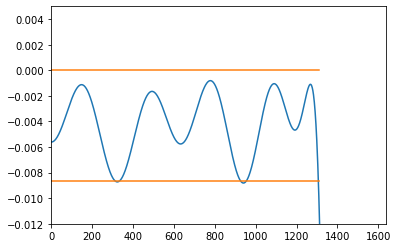

In [9]:
# passband ripple
plt.ylim(-.012, .005)
plt.xlim(0, (1<<16)/(2*r))
plt.plot(20*np.log10(np.absolute(np.fft.rfft(x/r, 1<<16))))
plt.plot(np.array([0, .4, np.nan, 0, .4])/r*(1<<16), 20*np.log10([1-1e-3, 1-1e-3, np.nan, 1, 1]))

# passband flatness
20*np.log10(1.001)

In [16]:
# group delay
np.argmax(np.fabs(x))/r

16.25

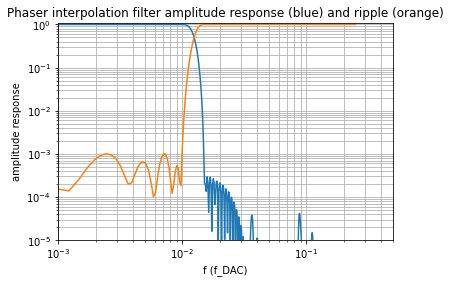

In [17]:
plt.xscale("log")
plt.xlabel("f (f_DAC)")
plt.xlim(1e-3, .5)
plt.yscale("log")
plt.ylim(1e-5, 1.1)
plt.ylabel("amplitude response")
plt.grid(which="both")
plt.title("Phaser interpolation filter amplitude response (blue) and ripple (orange)")
FIR(x).plot_freq(plt.gca(), r=r, f=4)

In [12]:
# overall impulse response of 20x interpolation chain (aply 20x zero stuffing to your data!)
x

array([-2.04411488e-12, -1.02205744e-11, -3.06617232e-11, -7.15440207e-11,
       -1.43088041e-10, -2.47337900e-10, -3.78161252e-10, -5.21249294e-10,
       -6.54116761e-10, -7.46101930e-10, -7.65840849e-10, -6.81267334e-10,
       -4.59612973e-10, -6.74071216e-11,  5.29523092e-10,  1.32165932e-09,
        2.25579201e-09,  3.23502038e-09,  4.11875242e-09,  4.72270494e-09,
        4.90307190e-09,  4.55652448e-09,  3.62021106e-09,  2.07175719e-09,
       -7.07343559e-11, -2.69990768e-09, -5.61915374e-09, -8.54261032e-09,
       -1.10951621e-08, -1.28124405e-08, -1.33658618e-08, -1.25626264e-08,
       -1.03457196e-08, -6.79391112e-09, -2.12175534e-09,  3.34559526e-09,
        9.17238997e-09,  1.48122799e-08,  1.96083180e-08,  2.27929590e-08,
        2.36176745e-08,  2.13529533e-08,  1.52883010e-08,  4.73224031e-09,
       -1.09876892e-08, -3.24138554e-08, -5.99585331e-08, -9.39039051e-08,
       -1.34402061e-07, -1.81474998e-07, -2.34462726e-07, -2.92023267e-07,
       -3.52132658e-07, -